This notebook is my practise to do EDA (exploratory data analysis)

I used to be interested on the daily covid data when covid hit Indonesia back in March and April. It had been a while, so let's have a look at them now

Data will be scrapped from:
* https://github.com/CSSEGISandData/COVID-19
* Our World in Data (for Indonesia): https://github.com/owid/covid-19-data/tree/master/public/data
* Covid data for Indonesia from SINTA (via KawalCOVID): http://sinta.ristekbrin.go.id/covid/datasets
* GEOjson for Indonesia: https://bitbucket.org/rifani/geojson-political-indonesia/src/master/

Summary of this notebook:
* Download Covid19 data for worldwide and Indonesia from several sources
* Download GEOjson map for Indonesia
* Worldwide: summary of latest data, worldwide map, death vs confirmed comparison
* Indonesia: summary of latest data, summary plots (total cases, daily cases, positive rate and mortality rate) and other random stats that I am interested in

New skills I picked up and applied on this notebook:
* First time using Git properly
* Using Plotly Express
* Extracting data from Google Sheet API
* Cleaning data. The spreadsheet is messy. Table are stacked on other tables in the same spreadsheet tab
* Extracted data is string. Not sure if there is a way to extract in a numeric format instead of converting it to float manually. For next time, maybe there is a way to just download from Google Sheet automatically and just pd.read_csv()
* Working with GEOjson data format and plotting an interactive map


# Covid19 in Indonesia

# Import necessary python libraries

In [1]:
#collapse
# download python libraries
from datetime import datetime, timedelta
import os
import glob
import wget
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import json
import plotly.express as px
import plotly.graph_objs as go

# for offline ploting
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

from IPython.display import HTML

# Import data

In [2]:
#collapse
# Download data from Github (daily)
os.chdir("C:/Users/Riyan Aditya/Desktop/ML_learning/Project4_EDA_Covid_Indo/datasets")

os.remove('time_series_covid19_confirmed_global.csv')
os.remove('time_series_covid19_deaths_global.csv')
os.remove('time_series_covid19_recovered_global.csv')

# urls of the files
urls = ['https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv', 
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv',
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv']

# download files
for url in urls:
    filename = wget.download(url)

100% [............................................................................] 265849 / 265849

# Clean & preprocess data

In [3]:
#collapse
# convert csv to df
confirmed_global = pd.read_csv('time_series_covid19_confirmed_global.csv')
deaths_global = pd.read_csv('time_series_covid19_deaths_global.csv')
recovered_global = pd.read_csv('time_series_covid19_recovered_global.csv')

In [4]:
#collapse
# Melt DF => switch rows of dates into column for simpler DF
dates = confirmed_global.columns[4:]

confirmed_globalv2 = confirmed_global.melt(id_vars = ['Province/State', 'Country/Region', 'Lat', 'Long'],
                                          value_vars = dates, var_name ='Date', value_name = 'Confirmed')
deaths_globalv2 = deaths_global.melt(id_vars = ['Province/State', 'Country/Region', 'Lat', 'Long'],
                                          value_vars = dates, var_name ='Date', value_name = 'Deaths')
recovered_globalv2 = recovered_global.melt(id_vars = ['Province/State', 'Country/Region', 'Lat', 'Long'],
                                          value_vars = dates, var_name ='Date', value_name = 'Recovered')
print(confirmed_globalv2.shape)
print(deaths_globalv2.shape)
print(recovered_globalv2.shape)

(70755, 6)
(70755, 6)
(67310, 6)


Why are there differences in number of rows between confirmed (or death) & recovered?

This seems to suggest some countries are missing their data

In [5]:
#collapse
# Combine df
covid_global = confirmed_globalv2.merge(deaths_globalv2, how='left', on = 
                                        ['Province/State', 'Country/Region', 'Lat', 'Long','Date']).merge(
                                        recovered_globalv2, how='left', on =
                                        ['Province/State', 'Country/Region', 'Lat', 'Long','Date'])

In [6]:
#collapse
# preprocessing
covid_global['Date'] = pd.to_datetime(covid_global['Date'])

#active cases
covid_global['Active'] = covid_global['Confirmed'] - covid_global['Deaths'] - covid_global['Recovered']

Grouby data by day

In [7]:
#collapse
# Data by day
covid_global_daily = covid_global.groupby('Date')['Confirmed','Deaths','Recovered','Active'].sum().reset_index()

Grouby data by country

In [8]:
#collapse
# Data by country
temp = covid_global[covid_global['Date'] ==max(covid_global['Date'])].reset_index(drop=True).drop('Date', axis = 1)
covid_global_percountry = temp.groupby('Country/Region')['Confirmed','Deaths','Recovered','Active'].sum().reset_index()

# Worldwide Data Viz

## Latest data

Show latest data

In [9]:
#collapse
# latest data
print('Date today',covid_global_daily['Date'].iloc[-1])
print('Total cases','{:,}'.format(covid_global_daily['Confirmed'].iloc[-1]))
print('Active cases','{:,}'.format(covid_global_daily['Active'].iloc[-1]))
print('Recovered cases','{:,}'.format(covid_global_daily['Recovered'].iloc[-1]))
print('Deaths cases','{:,}'.format(covid_global_daily['Deaths'].iloc[-1]))

Date today 2020-10-12 00:00:00
Total cases 37,801,526
Active cases 9,207,268.0
Recovered cases 26,108,249.0
Deaths cases 995,057.0


We almost reach 1M global death =(

In [10]:
#collapse
# plot
temp = covid_global_daily[['Date','Deaths','Recovered','Active']].tail(1)
temp = temp.melt(id_vars='Date',value_vars = ['Active','Deaths','Recovered'])
fig = px.treemap(temp, path=['variable'],values = 'value', height = 225)
fig.data[0].textinfo = 'label+text+value'

In [11]:
#collapse
HTML(fig.to_html(include_plotlyjs='cdn'))

## Total confirmed cases world map

World map interactive plot

In [12]:
#collapse
def plot_map(df, col, pal):
    df = df[df[col]>0]
    fig2 = px.choropleth(df, locations="Country/Region", locationmode='country names', 
                  color=col, hover_name="Country/Region", 
                  title=col, hover_data=[col], color_continuous_scale=pal)
    fig2.update_layout(coloraxis_showscale=False)
    return fig2
    

In [13]:
#collapse
fig2 = plot_map(covid_global_percountry, 'Confirmed', 'matter')
HTML(fig2.to_html(include_plotlyjs='cdn'))

## Treemap total confirmed cases 

In [14]:
#collapse
def plot_treemap(df,col):
    fig3 = px.treemap(df, path=["Country/Region"], values=col, height=700,
                 title=col, color_discrete_sequence = px.colors.qualitative.Dark2)
    fig3.data[0].textinfo = 'label+text+value'
    return fig3
    

In [15]:
#collapse
fig3 = plot_treemap(covid_global_percountry,'Confirmed')
HTML(fig3.to_html(include_plotlyjs='cdn'))

## Death vs confirmed

For top 50 countries with the highest total cases

In [16]:
#collapse
def human_format(num):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    # add more suffixes if you need them
    return '%.2f%s' % (num, ['', 'K', 'M', 'G', 'T', 'P'][magnitude])

In [17]:
#collapse
# plot
fig4 = px.scatter(covid_global_percountry.sort_values('Deaths', ascending=False).iloc[:50, :], 
                 x='Confirmed', y='Deaths', color='Country/Region', size='Confirmed', 
                 height=700, text='Country/Region', log_x=True, log_y=True, 
                 title='Deaths vs Confirmed (Scale is in log10)',
                hover_data={'Country/Region':True,'Confirmed':':,','Deaths':':,'})
fig4.update_traces(textposition='top center')
fig4.update_layout(showlegend=False)
HTML(fig4.to_html(include_plotlyjs='cdn'))

# Worldwide tests per thousand

Load data from Our World in Data

In [18]:
# collapse
# load data
url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'
df2 = pd.read_csv(url)

C:\Users\Riyan Aditya\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning:

Columns (1,24) have mixed types. Specify dtype option on import or set low_memory=False.



Parse to latest data

In [19]:
# hide
date_to_parse = '2020-10-11'
date_to_parse

'2020-10-11'

In [20]:
# collapse
# parse to latest data
df2_latest = df2.loc[df2.date == date_to_parse].reset_index()
df2_latest = df2_latest[:-2]

Eliminate countries that don't report new tests per thousand, sort by new tests per thousand value.

Note: not all countries report their new tests data regularly

Number of countries that report their data: 

In [21]:
# collapse
# eliminate countries that dont report new tests per thousand, sort by new tests per thousand value
df3 = df2_latest[~df2_latest['new_tests_per_thousand'].isnull()]
df3 = df3.loc[:, ['location','new_tests_per_thousand']]
df3 = df3.sort_values(by=['new_tests_per_thousand'], ascending = False)
df3.shape

(41, 2)

Top 10 countries best on tests per thousand:

In [22]:
# collapse
df3 = df3.reset_index()
df3.head(10)

index              location  new_tests_per_thousand
0      6  United Arab Emirates                  13.542
1     20               Bahrain                   5.167
2    161                Russia                   2.809
3    123              Maldives                   2.372
4    159                 Qatar                   2.232
5    118                Latvia                   1.773
6    175              Slovakia                   1.641
7     11               Austria                   1.534
8    189                Turkey                   1.296
9     85               Croatia                   1.215

And Indonesia:

In [23]:
# collapse
df3[df3['location']=='Indonesia']

index   location  new_tests_per_thousand
32     88  Indonesia                   0.081

we only tests 8% of our total population. Certainly much lower compared to other countries

# Indonesia

Data starts 18 Mar

## Import  data

In [24]:
#collapse
# find how many days in between 18 Mar to today (so we know how many rows to download)
from datetime import date

d0_total = date(2020, 3, 18)
d0_harian = date(2020,3,15)
d0_aktif = date(2020,3,21)
d0_sembuh = date(2020,3,21)
d0_deaths = date(2020,3,18)
d1 = date.today()

delta_total = d1 - d0_total
delta_harian = d1 - d0_harian
delta_aktif = d1 - d0_aktif
delta_sembuh = d1 - d0_sembuh
delta_deaths = d1 - d0_deaths

All df imported are strings. need to convert to int. Also had to remove all the comma in the thousand separator.

Note: you need "Credentials.json". You can get one by following this example: https://developers.google.com/sheets/api/quickstart/python

Code to import data from KawalCOVID:

In [25]:
#collapse
# %load GoogleSheet from KawalCovid19
from __future__ import print_function
import pickle
import os.path
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request

# If modifying these scopes, delete the file token.pickle.
SCOPES = ['https://www.googleapis.com/auth/spreadsheets.readonly']

# The ID and range of a sample spreadsheet.
SAMPLE_SPREADSHEET_ID = '1ma1T9hWbec1pXlwZ89WakRk-OfVUQZsOCFl4FwZxzVw'


def main():
    """Shows basic usage of the Sheets API.
    Prints values from a sample spreadsheet.
    """
    creds = None
    # The file token.pickle stores the user's access and refresh tokens, and is
    # created automatically when the authorization flow completes for the first
    # time.
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)
    # If there are no (valid) credentials available, let the user log in.
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                'credentials.json', SCOPES)
            creds = flow.run_local_server(port=0)
        # Save the credentials for the next run
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)

    service = build('sheets', 'v4', credentials=creds)
    


    # Call the Sheets API for total kasus ----------------------------------------------------------------
    sheet = service.spreadsheets()
    
    SAMPLE_RANGE_NAME = 'Timeline!A1:AZ'
    print(SAMPLE_RANGE_NAME)
    
    result = sheet.values().get(spreadsheetId=SAMPLE_SPREADSHEET_ID,
                                range=SAMPLE_RANGE_NAME).execute()
    values = result.get('values', [])
    df1 = pd.DataFrame(values)
    
    # Call the Sheets API for Statistik harian  ----------------------------------------------------------------
    sheet = service.spreadsheets()
    SAMPLE_RANGE_NAME = 'Statistik Harian!A1:AL'
    print(SAMPLE_RANGE_NAME)
    
    result = sheet.values().get(spreadsheetId=SAMPLE_SPREADSHEET_ID,
                                range=SAMPLE_RANGE_NAME).execute()
    values = result.get('values', [])
    
    df = pd.DataFrame(values)
    headers = df.iloc[0]
    covid_id  = pd.DataFrame(df.values[1:], columns=headers)
    covid_id.columns.values[0] = "Dates"
    covid_id = covid_id.replace(',','', regex=True).replace('-',' ', regex=True)
    covid_id = covid_id.replace('',0, regex=True)
    covid_id = covid_id.replace('#DIV/0!',0, regex=True)
    covid_id = covid_id.replace('#REF!',0, regex=True)
    covid_id = covid_id.set_index('Dates')
    covid_id = covid_id.replace('%','',regex=True).astype('float')/100
    covid_id = covid_id.astype('float')*100
    
    covid_id.index = pd.to_datetime(covid_id.index, format='%d %b')
    covid_id.index = covid_id.index + pd.DateOffset(year=2020)
    
    # Call the Sheets API for Population ----------------------------------------------------------------
    sheet = service.spreadsheets()
    
    SAMPLE_RANGE_NAME = 'Copy of Data PCR - Kemenkes!J2:M36'
    print(SAMPLE_RANGE_NAME)
    
    result = sheet.values().get(spreadsheetId=SAMPLE_SPREADSHEET_ID,
                                range=SAMPLE_RANGE_NAME).execute()
    values = result.get('values', [])
    df2 = pd.DataFrame(values)

    # return DF --------------------------------------------------------------------------------------------------
    return df1, covid_id, df2
    

indo_covid, covid_id, pop_id = main()

Timeline!A1:AZ
Statistik Harian!A1:AL


C:\Users\Riyan Aditya\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:837: PerformanceWarning:

Non-vectorized DateOffset being applied to Series or DatetimeIndex



Copy of Data PCR - Kemenkes!J2:M36


## Clean data

In [26]:
#collapse
indo_covid2 = indo_covid.copy()
indo_covid2 = indo_covid2.iloc[:, :-1]

In [27]:
#collapse
# find index of relevant tables
index_tk = indo_covid2.loc[indo_covid2[indo_covid2.columns[0]] == 'Total Kasus'].index[0]
index_ka = indo_covid2.loc[indo_covid2[indo_covid2.columns[0]] == 'Kasus Aktif'].index[0]
index_ks = indo_covid2.loc[indo_covid2[indo_covid2.columns[0]] == 'Sembuh'].index[0]
index_km = indo_covid2.loc[indo_covid2[indo_covid2.columns[0]] == 'Meninggal Dunia'].index[0]

#index_tk, index_ka, index_ks, index_km

In [28]:
#collapse
#Split table into total cases, active cases, recovered cases and deaths
#Then set dates as the index

total_cases =  indo_covid2[index_tk:index_tk+delta_total.days+1:].rename(
    columns=indo_covid2.iloc[0]).drop(indo_covid2.index[0]).replace('-',' ', regex=True).set_index('Total Kasus')
active_cases = indo_covid2[index_ka:index_ka+delta_aktif.days+1:].rename(
    columns=indo_covid2.iloc[index_ka]).drop(indo_covid2.index[index_ka]).replace('-',' ', regex=True).set_index('Kasus Aktif')
recovered_cases = indo_covid2[index_ks:index_ks+delta_sembuh.days+1:].rename(
    columns=indo_covid2.iloc[index_ks]).drop(indo_covid2.index[index_ks]).replace('-',' ', regex=True).set_index('Sembuh')
deaths_cases = indo_covid2[index_km:index_km+delta_deaths.days+1:].rename(
    columns=indo_covid2.iloc[index_km]).drop(indo_covid2.index[index_km]).replace('-',' ', regex=True).set_index('Meninggal Dunia')

In [29]:
#collapse
# clean df
def clean_df(df):
    
    mask = df.applymap(lambda x: x is None)
    cols = df.columns[(mask).any()]
    for col in df[cols]:
        df.loc[mask[col], col] = 0
    
    df = df.replace(',','', regex=True).replace('',0, regex=True)
    df = df.astype('float64')
    df.index = pd.to_datetime(df.index, format='%d %b')
    df.index = df.index + pd.DateOffset(year=2020)
    
    return df


total_cases = clean_df(total_cases)    
active_cases = clean_df(active_cases)
recovered_cases = clean_df(recovered_cases)
deaths_cases = clean_df(deaths_cases)

In [30]:
#collapse
# generate new cases, new recovered, new deaths
new_cases = total_cases.diff()
new_recovered = recovered_cases.diff()
new_deaths = deaths_cases.diff()

## Latest Indonesian data

In [31]:
#collapse
# display latest data
print(d1)
print('Total cases','{:,}'.format(covid_id['Total kasus'][-1]))
print('Active cases','{:,}'.format(covid_id['Kasus aktif'][-1]))
print('Total recovered','{:,}'.format(covid_id['Sembuh'][-1]))
print('Total deaths','{:,}'.format(covid_id['Meninggal\nDunia'][-1]))

2020-10-13
Total cases 340,622.0
Active cases 65,299.0
Total recovered 263,296.0
Total deaths 12,027.0


## Total cases plot

Latest Indonesian Covid data:

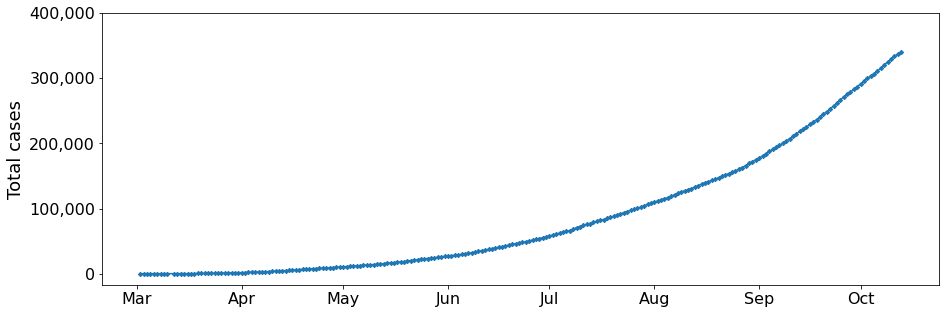

In [32]:
#collapse
# codes
import matplotlib.ticker as mtick
from matplotlib.dates import DateFormatter
from pandas.plotting import *
register_matplotlib_converters() 
fig, ax = plt.subplots(1, 1, figsize=(15,5))

ax.plot(covid_id.index,covid_id['Total kasus'],'-D',markersize = 3)

plt.yticks(np.arange(0,400001,100000), fontsize=16)
plt.xticks( fontsize=16)
plt.ylabel('Total cases', fontsize=18)

ax.get_yaxis().set_major_formatter(mtick.FuncFormatter(lambda x, p: format(int(x), ',')))
myFmt = DateFormatter("%b")
ax.xaxis.set_major_formatter(myFmt)

plt.show()

## Daily cases

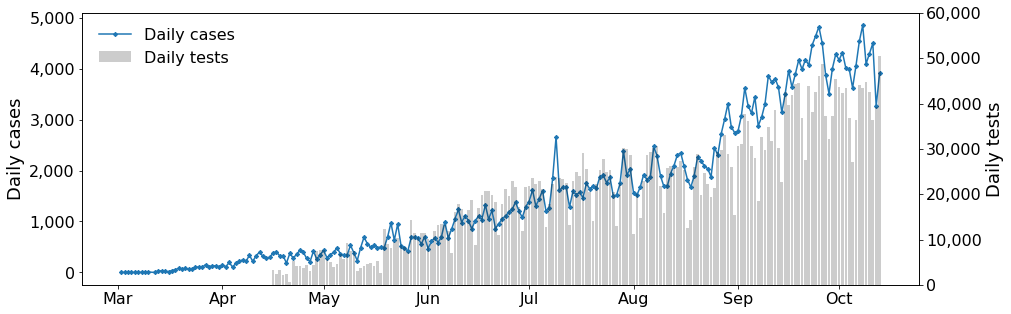

In [33]:
#collapse
# codes

fig, ax = plt.subplots(1, 1, figsize=(15,5))
ln1 = ax.plot(covid_id.index,covid_id['Kasus baru'],'-D',markersize = 3,label = 'Daily cases')
ax2 = ax.twinx()
ln2 = ax2.bar(covid_id.index,covid_id['Spesimen'],alpha = 0.2, color = 'black',label = 'Daily tests')

ax.tick_params(axis='both', which='major', labelsize=16)
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2.set_ylim([0,60000])
ax.get_yaxis().set_major_formatter(mtick.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.get_yaxis().set_major_formatter(mtick.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_ylabel('Daily cases',fontsize = 18)
ax2.set_ylabel('Daily tests',fontsize = 18)

myFmt = DateFormatter("%b")
ax.xaxis.set_major_formatter(myFmt)

#legend
fig.legend(bbox_to_anchor=(0.2,1), bbox_transform=ax.transAxes, fontsize = 16, frameon=False)


plt.show()

Unsurprisingly, daily cases are highly correlated with number of daily tests

## Positive rate

This is a 7 day rolling average of new cases divided by number of people that are tested.

About 16% of the population tested returned a positive Covid test result.

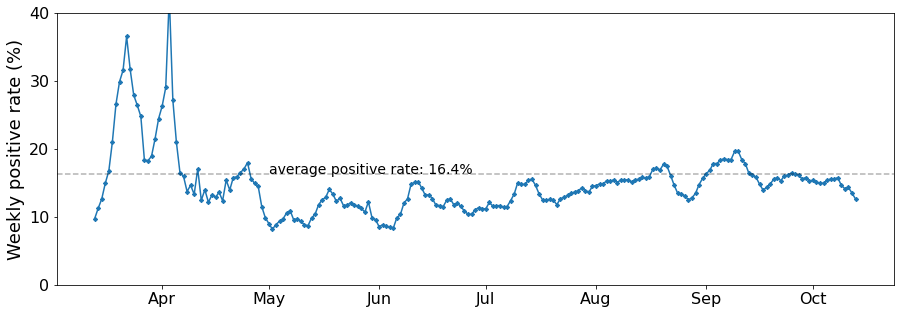

In [34]:
#collapse
# codes
import matplotlib.ticker as mtick
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots(1, 1, figsize=(15,5))

avg_pos_rate = covid_id['Positive rate harian'].mean()
ax.plot(covid_id.index,covid_id['Positive rate mingguan'],'-D',markersize = 3)
plt.axhline(y=avg_pos_rate, color='k', linestyle='--', alpha = 0.3)
plt.text(pd.to_datetime("2020-05-01"),avg_pos_rate+0.02,"average positive rate: "+str(round(avg_pos_rate,1))+"%",fontsize = 14)


ax.set_ylim([0,40])
plt.yticks(np.arange(0,41,10), fontsize=16)
plt.xticks( fontsize=16)
plt.ylabel('Weekly positive rate (%)', fontsize=18)

ax.get_yaxis().set_major_formatter(mtick.FuncFormatter(lambda x, p: format(int(x), ',')))
myFmt = DateFormatter("%b")
ax.xaxis.set_major_formatter(myFmt)

plt.show()

## Mortality rate

Average mortality rate is 5.5. However, this is likely affected by the data collected during March. This seems to indicate data was not collected (or the data collection is not fully functional yet). More accurate perhaps is the recent mortality rate, which is around 3.6.

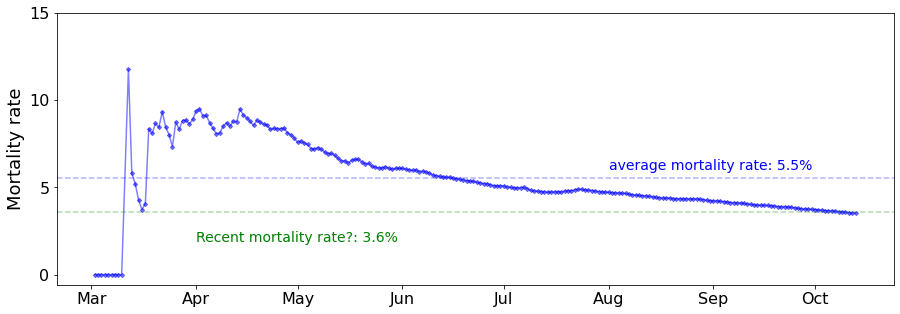

In [35]:
#collapse
# codes

#death_rate = df_indo['2020-03-1'::].new_deaths/df_indo['2020-03-1'::].new_cases*100
avg_death_rate = covid_id['Tingkat kematian (seluruh kasus)'].mean()

fig, ax = plt.subplots(1, 1, figsize=(15,5))

ax.plot(covid_id.index, covid_id['Tingkat kematian (seluruh kasus)'] ,'-D',color ='b',markersize = 3,alpha = 0.5)
plt.axhline(y=avg_death_rate, color='b', linestyle='--', alpha = 0.3)
plt.text(pd.to_datetime("2020-08-01"),avg_death_rate+0.5,"average mortality rate: "+str(round(avg_death_rate,1))+'%',fontsize = 14,color='blue')
plt.axhline(y=3.6, color='g', linestyle='--', alpha = 0.3)
plt.text(pd.to_datetime("2020-04-01"),3.2-1.3,"Recent mortality rate?: "+str(3.6)+'%',fontsize = 14,color='g')

plt.yticks(np.arange(0,15.1,5), fontsize=16)
plt.xticks( fontsize=16)
plt.ylabel('Mortality rate', fontsize=18)

myFmt = DateFormatter("%b")
ax.xaxis.set_major_formatter(myFmt)

plt.show()

# Interactive Province Map

In [36]:
#collapse
# Load GEOjson data
with open('IDN_adm_1_province.json') as data_file:
    indo_map = json.load(data_file)

In [37]:
#collapse
# temp
a = []
for x in range(len(indo_map['features'])):
        y = indo_map["features"][x]['properties']['NAME_1']
        a.append(y)

In [38]:
#collapse
# transpose total cases per province
indo_cases = total_cases.tail(1).T.reset_index()
indo_cases.columns = ['Province','Total_cases']
indo_cases = indo_cases[:-1]

# rename Province based on JSON name
indo_cases['Province'] = ['Aceh','Bali','Banten','Bangka-Belitung','Bengkulu','Yogyakarta','Jakarta Raya','Jambi',
                            'Jawa Barat','Jawa Tengah','Jawa Timur','Kalimantan Barat','Kalimantan Timur',
                             'Kalimantan Tengah','Kalimantan Selatan','Kalimantan Utara','Kepulauan Riau',
                             'Nusa Tenggara Barat','Sumatera Selatan','Sumatera Barat','Sulawesi Utara',
                          'Sumatera Utara','Sulawesi Tenggara','Sulawesi Selatan','Sulawesi Tengah','Lampung',
                          'Riau','Maluku Utara','Maluku','Irian Jaya Barat','Papua','Sulawesi Barat',
                          'Nusa Tenggara Timur','Gorontalo']

# transpose new cases per province
indo_cases2 = new_cases.tail(1).T.reset_index()
indo_cases2.columns = ['Province','New_cases']
indo_cases2 = indo_cases2[:-1]

#combine DF
indo_cases['New_cases'] = indo_cases2['New_cases']


In [39]:
#collapse
# plot map

fig5 = px.choropleth(indo_cases, geojson=indo_map, locations=indo_cases['Province'],
                    color=indo_cases['Total_cases'], # lifeExp is a column of gapminder
                    color_continuous_scale=px.colors.sequential.Reds,featureidkey="properties.NAME_1")


fig5.update_geos(fitbounds="locations")
fig5.update_layout(title = 'Total cases per province')
HTML(fig5.to_html(include_plotlyjs='cdn'))


In [40]:
#collapse
# plot map

fig6 = px.choropleth(indo_cases, geojson=indo_map, locations=indo_cases['Province'],
                    color=indo_cases['New_cases'], # lifeExp is a column of gapminder
                    color_continuous_scale=px.colors.sequential.Reds,featureidkey="properties.NAME_1")


fig6.update_geos(fitbounds="locations")
fig6.update_layout(title = 'New cases per province ('+str(d1)+')')
fig6.update_layout(coloraxis_colorbar=dict(title='Daily cases'))

HTML(fig6.to_html(include_plotlyjs='cdn'))

Both the total cases and new cases indicate that most cases are in Java. This is expected since Java is the island with the most dense population. Data from other sources also indicate that most Covid tests are being performed in Java (especially Jakarta and East Java).

# Other stats in Indonesia

## Top 10 total cases and daily cases (last data)

In [41]:
# collapse
def plot_hbar_sidexside(df1, col1, n1, df2, col2, n2, hover_data=[]):
    from plotly.subplots import make_subplots
    fig7 = px.bar(df1.sort_values(col1).tail(n1), 
                 x=col1, y="Province",  
                 text=col1, orientation='h', width=700, hover_data=hover_data,
                 color_discrete_sequence = px.colors.qualitative.Dark2)
    fig8 = px.bar(df2.sort_values(col2).tail(n2), 
                 x=col2, y="Province",  
                 text=col2, orientation='h', width=700, hover_data=hover_data,
                 color_discrete_sequence = px.colors.qualitative.Dark2)
    trace1 = fig7['data'][0]
    trace2 = fig8['data'][0]
    
    fig9 = make_subplots(rows=1, cols=2, shared_xaxes=False)
    fig9.add_trace(trace1, row=1, col=1)
    fig9.update_layout(title='Provinces with the highest total cases                  Provinces with the highest daily cases ('+str(d1)+')')
    fig9.add_trace(trace2, row=1, col=2)
    #fig2.update_layout(title='Violin per feature2')
    return fig9

fig9 = plot_hbar_sidexside(indo_cases,'Total_cases',10,indo_cases,'New_cases',10,)
HTML(fig9.to_html(include_plotlyjs='cdn'))

## Cases vs population

Clean population related data

In [42]:
# collapse
# cleaning population data
pop_id2 = pop_id.copy()
pop_id2 = pop_id2 .rename(columns=pop_id2 .iloc[0]).drop(pop_id2 .index[0])
pop_id2.columns = ['Province','suspect','Jumlah PCR+TCM','Population']

# rename province to make it the same as the GEOjson
pop_id2.at[3,'Province'] = 'Bangka-Belitung'
pop_id2.at[6,'Province'] = 'Yogyakarta'
pop_id2.at[7,'Province'] = 'Jakarta Raya'
pop_id2.at[25,'Province'] = 'Irian Jaya Barat'

# convert to numeric
pop_id2 = pop_id2.replace(',','', regex=True).replace('',0, regex=True)
pop_id2['suspect'] = pd.to_numeric(pop_id2['suspect'])
pop_id2['Jumlah PCR+TCM'] = pd.to_numeric(pop_id2['Jumlah PCR+TCM'])
pop_id2['Population'] = pd.to_numeric(pop_id2['Population'])

indo_cases = indo_cases.merge(pop_id2,how='left', left_on='Province', right_on='Province')

In [43]:
# collapse
# plot
fig10 = px.scatter(indo_cases, 
                 y='Total_cases', x='Population', color='Total_cases', size='Total_cases', 
                 height=700, text='Province', log_x=True, log_y=True, 
                 title='Total cases vs Population (Scale is in log10)',
                hover_data={'Province':True,'Total_cases':':,','Population':':,'})
fig10.update_traces(textposition='top center')
fig10.update_layout(showlegend=False)
HTML(fig10.to_html(include_plotlyjs='cdn'))

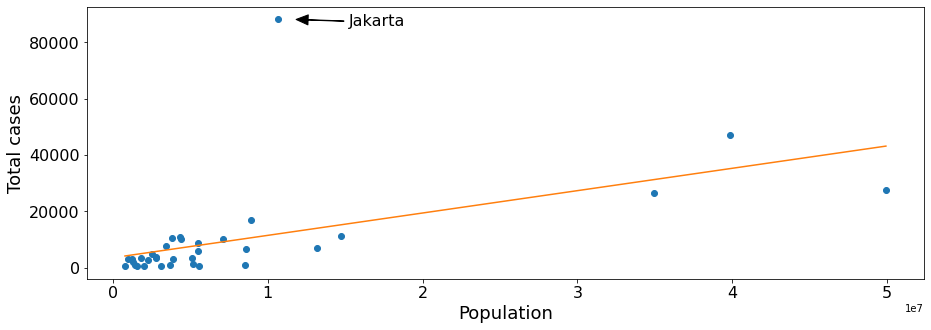

In [44]:
# collapse
# Plot LBF
fig, ax = plt.subplots(1, 1, figsize=(15,5))

from numpy.polynomial.polynomial import polyfit

y,x = indo_cases.Total_cases,indo_cases.Population
plt.plot(x,y,'o')

b,m = polyfit(x, y, 1)
plt.plot(x.sort_values(), m*x.sort_values() + b)

jkt_data = indo_cases[indo_cases['Province']=='Jakarta Raya']

plt.xlabel('Population',fontsize = 18)
plt.ylabel('Total cases',fontsize = 18)
plt.yticks(np.arange(0,80001,20000), fontsize=16)
plt.xticks(np.arange(0,50000001,10000000), fontsize=16)

ax.annotate('Jakarta', xy=(jkt_data['Population']+1000000, jkt_data['Total_cases']),  xycoords='data',
            xytext=(0.38, 0.975), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05, width = 0.4, headwidth = 10),
            horizontalalignment='right', verticalalignment='top',fontsize = 16
            )

plt.show()

That's weird. Jakarta has a significantly higher total cases relative to its population (a proxy for density)

Unless, if jakarta tests the proportion of their population much higher compared to other provinces?

Unfortunately, I cannot find data regarding tests per province. However, there is an article below. Based on the data there, Jakarta ran 35k tests per 1M population. Three times as much as the second place, Bali (12k tests / 1M population). Hence it might be possible the high covid rate in Jakarta per population is due to the number of testing here

https://www.thejakartapost.com/news/2020/07/22/testing-disparity-among-regions-a-challenge-for-covid-19-response.html

## Java vs non Java

Create java and non-java category.

In [45]:
# collapse
# create java and non-java category
indo_cases['Java'] = 'Non-Java'
indo_cases.at[[2,5,6,8,9,10],'Java'] = indo_cases['Province']

In [49]:
# collapse
# plot
from plotly.subplots import make_subplots

fig11 = px.pie(indo_cases, values ='Total_cases', names = 'Java',color='Java', 
              color_discrete_sequence=px.colors.sequential.Teal)

fig12 = (px.pie(indo_cases, values ='New_cases', names = 'Java'
            ,title = 'Total cases'))
trace1 = fig11['data'][0]
trace2 = fig12['data'][0]

fig13 = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig13.add_trace(trace1, row=1, col=1)
fig13.add_trace(trace2, row=1, col=2)

fig13.update_traces(textposition='inside', textinfo='percent+label')
fig13.update_traces(hole =.4,hoverinfo="label+percent+name")
fig13.update_traces(textposition = "outside")
fig13.update_layout(showlegend=False)
fig13.update_layout(title_text="Total cases and new cases ("+str(d1)+')'
    ,annotations =[dict(text='Total', x=0.18, y=0.5, font_size=20, showarrow=False),
                              dict(text='New', x=0.82, y=0.5, font_size=20, showarrow=False)])
HTML(fig13.to_html(include_plotlyjs='cdn'))

It can be observed that 60% of the reported Covid19 cases in Indonesia is in Java. The trend still continues for the new cases reported daily